In [3]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import math

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is the last element, shares: Number of shares

In [171]:
# loading of dataset 
def load_dataset(is_normalize=True):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader) # skip the first row
        temp_data = []
        temp_label = []
        fields_to_avoid = [0, 9, 12, 13, 14, 15, 16, 17, 21, 30, 31, 32, 33, 34, 35, 36, 37, 51, 
                           8, 10, 21, 34, 38, 39, 41, 60]
        for idx, row in enumerate(reader):
            slice_row = []
#             for row_idx, row_data in enumerate(row):
#                 if not row_idx in fields_to_avoid:
#                     slice_row.append(row_data)
            slice_row = row[1:-1]
            temp_data.append(slice_row)
            temp_label.append(row[-1])
            
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.StandardScaler()
            temp_data = scaler.fit_transform(temp_data)
            # last item uses MinMaxScaler
            temp_label = np.array(temp_label).reshape(-1, 1)
            scaler = preprocessing.MinMaxScaler()
            temp_label = scaler.fit_transform(temp_label)
            print('Data is normalize')
        else:
            print('No normalize apply')
        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))
    return np.array(dataset), np.array(labels).reshape(len(labels), 1)

def reject_outliers(data, m=1.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    print(len(s))
    print(m)
    result = data[s<m]
    return result.reshape(len(result), 1)

In [172]:
# Splitting of dataset into train and test
# Dataset if normalize using MinMaxScaler
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=False)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=True, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

No normalize apply
Dataset shape: (39644, 59), Labels: (39644, 1)
x_train: (31715, 59), y_train: (31715, 1)
x_test: (7929, 59), y_test: (7929, 1)


39644
1.0
(19122, 1)
Shares max value: 1900.0
Shares min value: 801.0
Shares avg value: 1249.613168078653


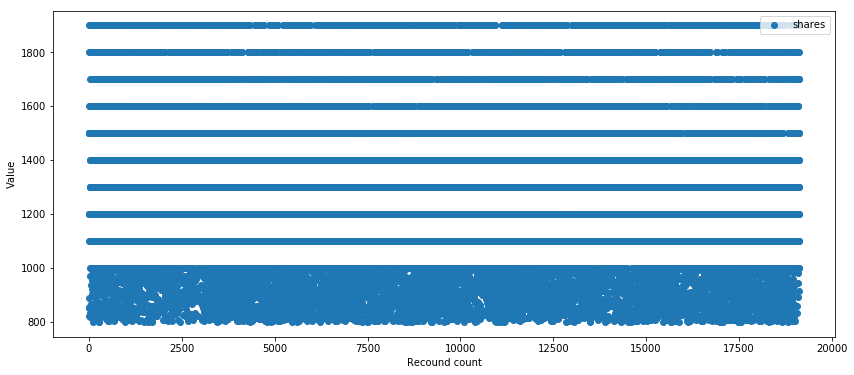

In [173]:
labels = reject_outliers(labels)

print(labels.shape)
print('Shares max value: {0}'.format(np.max(labels)))
print('Shares min value: {0}'.format(np.min(labels)))
print('Shares avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Recound count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

show_graph(labels)

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [52]:
# build model
l2_kernal = 0.001

model = Sequential()
model.add(Dense(128, input_dim=59, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# model = Sequential()
# model.add(Dense(128, input_dim=19, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mean_squared_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               7680      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total para

In [53]:
# training with callbacks
saved_weights_name = 'best_weights_mlp.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=10,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, reduce_lr],
                      verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/10
31715/31715 [==============================] - 2s 57us/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 1.8455e-04 - val_mean_squared_error: 1.8455e-04
Epoch 2/10
31715/31715 [==============================] - 2s 48us/step - loss: 3.5246e-04 - mean_squared_error: 3.5246e-04 - val_loss: 1.8464e-04 - val_mean_squared_error: 1.8464e-04
Epoch 3/10
31715/31715 [==============================] - 1s 47us/step - loss: 2.6317e-04 - mean_squared_error: 2.6317e-04 - val_loss: 1.8431e-04 - val_mean_squared_error: 1.8431e-04
Epoch 4/10
31715/31715 [==============================] - 1s 45us/step - loss: 2.3969e-04 - mean_squared_error: 2.3969e-04 - val_loss: 1.8382e-04 - val_mean_squared_error: 1.8382e-04
Epoch 5/10
31715/31715 [==============================] - 2s 51us/step - loss: 2.1079e-04 - mean_squared_error: 2.1079e-04 - val_loss: 1.8317e-04 - val_mean_squared_error: 1.8317e-04
Epoch 6/10
31715/31715 [====================

7929/7929 [==============================] - 0s 22us/step
loss: 0.00018
mean_squared_error: 0.00018
explained_variance_score: -3037.897833
mean_absolute_error: 0.003417
mean_squared_log_error: 0.000133
median_absolute_error: 0.001175
r2_score: -3246.773801


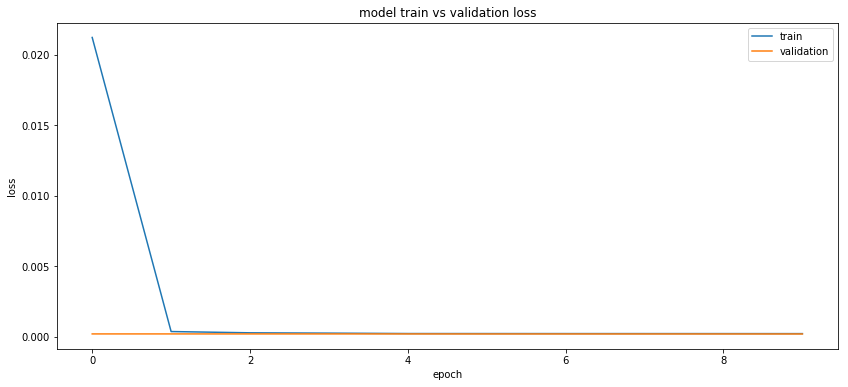

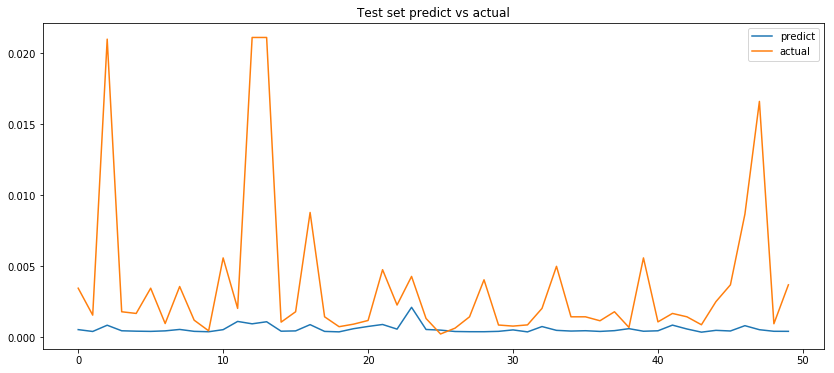

In [54]:
# showing results
scores = model.evaluate(x_test, y_test)
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50], label="predict")
plt.plot(y_test[:50], label="actual")
plt.legend(loc='upper right', borderaxespad=0.5)
plt.show()

In [ ]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

kfold_result = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # build model
    model = Sequential()
    model.add(Dense(128, input_dim=58, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.00001,
                           patience=10,
                           mode='min',
                           verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=4,
                                  min_lr=0.000001,
                                  verbose=1)

    model.fit(x_train, y_train,
              epochs=50,
              validation_data=(x_test, y_test),
              callbacks=[early_stop, reduce_lr],
              verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    print('r2_score: {0}'.format(round(r2, 6)))
    kfold_result.append([scores[0], scores[1], r2])

In [ ]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print()

print('kfold average loss: {0}'.format(round(avg_loss, 6)))
print('kfold average mse: {0}'.format(round(avg_mse, 6)))
print('kfold average r2: {0}'.format(round((avg_r2/5), 6)))